## Factorization Median Expansion for Boolean Matrix Factorization (MEBMF)

In [164]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

(array([400.,   0.,   0.,   0.,   0., 300.,   0.,   0.,   0., 300.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

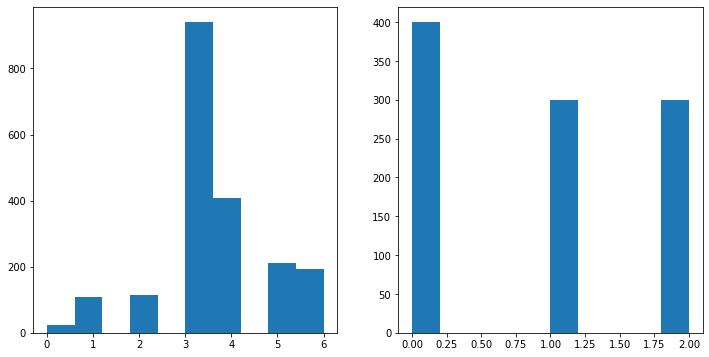

In [202]:
## Specify the number of cells N, factors F, sensitiviteit s and noise ns

N = 1000
F = 2000
s = 0.4
ns = 0.05

## Generate 5 factors: 0-2 markers 3 - noise 4 - constituitively active 5 - Shared between 0 and 1 6 - shared between 1 and 2
factors = np.random.choice(7, F, p=[0.01, 0.05, 0.05, 0.49, 0.2, 0.1, 0.1])

## Generate cluster labels 0-2
# clusters = np.random.choice(3, N, p=[0.4, 0.3, 0.3])
clusters = np.concatenate((np.repeat(0, 400), np.repeat(1, 300), np.repeat(2, 300)), axis = 0)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.hist(factors)

ax2 = fig.add_subplot(122)
ax2.hist(clusters)

Total feats: 811989.0
Total feats after dropouts: 324571.0


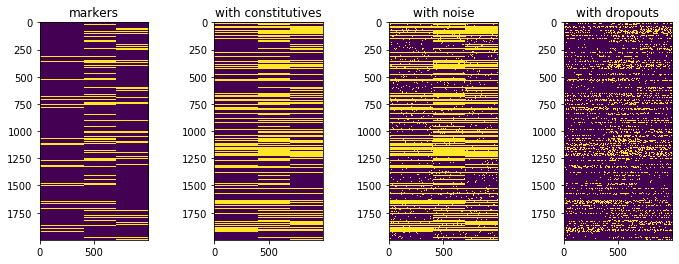

In [203]:
## Generate a matrix Xnm of factors x cells
Xnm = np.zeros([F,N])

## Populate the matrix with markers
for x in np.unique(clusters):
    row = factors == x
    col = clusters == x
    Xnm = Xnm + np.outer(row, col)
    
## For factor 5 we add both col 0 and 1
row = factors == 5
col = (clusters == 0) | (clusters == 1)
Xnm = Xnm + np.outer(row,col)

## For factor 5 we add both col 2 and 1
row = factors == 6
col = (clusters == 2) | (clusters == 1)
Xnm = Xnm + np.outer(row,col)

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(141)    
ax1.imshow(Xnm)
ax1.set_title('markers')

## Add constitutive features
Xnm[factors == 4, :] = 1

ax2 = fig.add_subplot(142)    
ax2.imshow(Xnm)
ax2.set_title('with constitutives')

## Add noise
Xnm = Xnm + np.random.choice(2, F * N, p=[1-ns, ns]).reshape(F, N)
Xnm = np.clip(Xnm, 0, 1)

ax3 = fig.add_subplot(143)    
ax3.imshow(Xnm)
ax3.set_title('with noise')

print(f'Total feats: {np.sum(Xnm)}')

## Add dropouts
dropout = np.random.choice(2, N*F, p=[s,1-s]).reshape(F,N)
Xnm = Xnm - dropout
Xnm = np.clip(Xnm, 0, 1)

ax4 = fig.add_subplot(144)    
ax4.imshow(Xnm)
ax4.set_title('with dropouts')

print(f'Total feats after dropouts: {np.sum(Xnm)}')

np.savetxt("test.csv", Xnm, delimiter=",")

Text(0.5, 1.0, 'NBins')

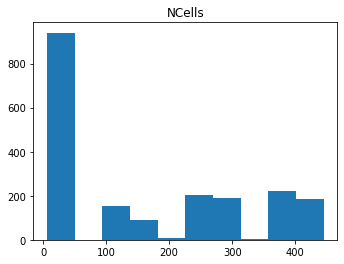

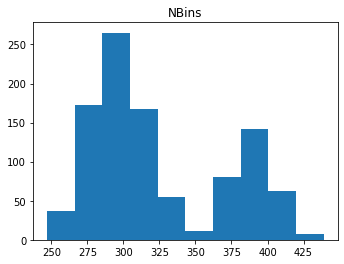

In [204]:
NCells = np.sum(Xnm, axis = 1)
NBins = np.sum(Xnm, axis = 0)

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)    
ax1.hist(NCells)
ax1.set_title('NCells')

fig = plt.figure(figsize=(12,4))
ax2 = fig.add_subplot(122)    
ax2.hist(NBins)
ax2.set_title('NBins')

Shape of the reduced dataframe (10, 1000)
We now have a (1000, 2) dataframe that we can use to plot


Text(0.5, 1.0, 'tSNE of the first 10 components')

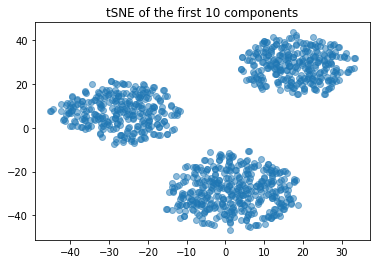

In [205]:
## First we setup the PCA object and we fit our normalized data to it.
from sklearn.decomposition import PCA

ncomp = 10 
PCs = PCA(n_components=ncomp)
PCs.fit(Xnm)
print(f'Shape of the reduced dataframe {PCs.components_.shape}')

from sklearn.manifold import TSNE
TSNE = TSNE(init='pca') ## TSNE uses a random seed to initiate, meaning that the results don't always look the same!
TSNE.fit(PCs.components_.T)
print(f'We now have a {TSNE.embedding_.shape} dataframe that we can use to plot')

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.scatter(TSNE.embedding_[:,0], TSNE.embedding_[:,1], alpha=.5)
ax.set_title(f'tSNE of the first {ncomp} components')

In [206]:
Xnm.shape

(2000, 1000)

In [299]:
class MEBF(object):
    def __init__(self, Τ: float = 0.6, k: int = 1000, p: float = 0.05):
        """        
        Args:

        Remarks:

        """
        self.T = Τ
        self.k = k
        self.p = p
    
    def fit(self, data) -> None:
        ''''
        Args:

        Returns:
        Remarks:

        '''
        if min(data.shape[0],data.shape[1]) < self.k:
            self.k = min(data.shape[0],data.shape[1])
        
        m1 = data
        s = np.sum(m1)
        mat_b = None
        mat_c = None
        
        for i in range(self.k):
            if np.sum(m1) <= self.p*s:
                r = []
                r[0] = mat_b
                r[1] = mat_c
                return r
            
            C1 = 0
            B1 = np.zeros(m1.shape[0])
            B1_use = B1
            B2 = np.zeros(m1.shape[1])
            B2_use = B2
            col = np.sum(m1, axis=0)
            row = np.sum(m1, axis=1)
            
            ## Start with columns
            if np.median(col[col>0]) > 1:
                tmp = np.ix_(np.sum(m1, axis=0) == min(col[col>=np.median(col[col>0])]))
                if len(tmp)==1:
                    B1 = m1[:,tmp[0]]
#                     B2[np.sum(m1[B1==1,:], axis=0) >= np.min(self.T*np.sum(B1)+1,np.sum(B1))] = 1
                    return np.sum(m1[B1==1], axis=0)
                
#                 which(colSums(m1[which(B1==1),])
                
#                 return tmp
  

model = MEBF()
model.fit(data=Xnm.T)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 2000 but corresponding boolean dimension is 4

In [ ]:
data[]

In [182]:
   
    # START with column
    if(median(COL[COL>0])>1){
      TEMP<-which(colSums(m1)==min(COL[which(COL>=median(COL[COL>0]))]))
      if(length(TEMP)==1){
        B1<-m1[,TEMP]
        B2[which(colSums(m1[which(B1==1),])>=min(Thres*sum(B1)+1,sum(B1)))]<-1
        C2<-(sum(B1)-1)*(sum(B2)-1)-sum(m1[which(B1==1),which(B2==1)]==0)
        if(C2>C1){
          C1<-C2
          B1_use<-B1
          B2_use<-B2
        }
        B1<-rep(0,nrow(m1))
        B2<-rep(0,ncol(m1))
      }else{
        for(j in 1:length(TEMP)){
          B1<-m1[,TEMP[j]]
          B2[which(colSums(m1[which(B1==1),])>=min(Thres*sum(B1)+1,sum(B1)))]<-1
          C2<-(sum(B1)-1)*(sum(B2)-1)-sum(m1[which(B1==1),which(B2==1)]==0)
          if(C2>C1){
            C1<-C2
            B1_use<-B1
            B2_use<-B2
          }
          B1<-rep(0,nrow(m1))
          B2<-rep(0,ncol(m1))
        }
      }
    }
    
    # START with ROW
    if(median(ROW[ROW>0])>1){
      TEMP<-which(rowSums(m1)==min(ROW[ROW>=median(ROW[ROW>0])]))
      if(length(TEMP)==1){
        B2<-m1[TEMP,]
        B1[which(rowSums(m1[,which(B2==1)])>=min(Thres*sum(B2)+1,sum(B2)))]<-1
        C2<-(sum(B1)-1)*(sum(B2)-1)-sum(m1[which(B1==1),which(B2==1)]==0)
        if(C2>C1){
          C1<-C2
          B1_use<-B1
          B2_use<-B2
        }
        B1<-rep(0,nrow(m1))
        B2<-rep(0,ncol(m1))
      }else{
        for(j in 1:length(TEMP)){
          B2<-m1[TEMP[j],]
          B1[which(rowSums(m1[,which(B2==1)])>=min(Thres*sum(B2)+1,sum(B2)))]<-1
          C2<-(sum(B1)-1)*(sum(B2)-1)-sum(m1[which(B1==1),which(B2==1)]==0)
          if(C2>C1){
            C1<-C2
            B1_use<-B1
            B2_use<-B2
          }
          B1<-rep(0,nrow(m1))
          B2<-rep(0,ncol(m1))
        }
      }
    }
    
    if(C1==0){
      ROW<-order(rowSums(m1),decreasing = T)
      COL<-order(colSums(m1),decreasing = T)
      # start from ROW
      B1_1<-rep(0,nrow(m1))
      if(length(which(rowSums(m1[,COL[1:2]])==2))>1){
        B1_1[which(rowSums(m1[,COL[1:2]])==2)]<-1
        B1_2<-rep(0,ncol(m1))
        B1_2[colSums(m1[which(B1_1==1),])>=min((Thres*sum(m1[which(B1_1==1),COL[1]])+1),sum(m1[which(B1_1==1),COL[1]]))]<-1
        C1<-(sum(B1_1)-1)*(sum(B1_2)-1)-sum(m1[which(B1_1==1),which(B1_2==1)]==0)
      }else{
        C1<-(-Inf)
      }
      
      # start from COL
      B2_2<-rep(0,ncol(m1))
      if(length(which(colSums(m1[ROW[1:2],])==2))>1){
        B2_2[which(colSums(m1[ROW[1:2],])==2)]<-1
        B2_1<-rep(0,nrow(m1))
        B2_1[rowSums(m1[,which(B2_2==1)])>=min(Thres*sum(m1[ROW[1],which(B2_2==1)])+1,sum(m1[ROW[1],which(B2_2==1)]))]<-1
        C2<-(sum(B2_1)-1)*(sum(B2_2)-1)-sum(m1[which(B2_1==1),which(B2_2==1)]==0)
      }else{
        C2<-(-Inf)
      }
      
      if((C1==(-Inf))&(C2==(-Inf))){
        break
      }else{
        if(C1>C2){
          B1_use<-B1_1
          B2_use<-B1_2
          m1[which(B1_1==1),which(B1_2==1)]<-0
        }else{
          B1_use<-B2_1
          B2_use<-B2_2
          m1[which(B2_1==1),which(B2_2==1)]<-0
        }
      }
    }
    MAT_B<-cbind(MAT_B,B1_use)
    MAT_C<-rbind(MAT_C,B2_use)
    m1[which(MAT_B[,i]==1),which(MAT_C[i,]==1)]<-0
  }
  result<-list()
  result[[1]]<-MAT_B
  result[[2]]<-MAT_C
  return(result)
}

SyntaxError: invalid syntax (<ipython-input-182-9798fb5512ad>, line 33)